# Authentication
Loads variables from `.env`:
- `LLM_API_KEY`: **REQUIRED** Open Router API Key (other LLM providers are valid if the BASE_URL matches...)
- `LLM_BASE_URL`: Defaults to `https://openrouter.ai/api/v1`

In [1]:
import os
from textwrap import shorten
from dotenv import load_dotenv
from master_agent.llm import LlmClient, SubtasksGenerator

load_dotenv()

llm_api_key = os.getenv('LLM_API_KEY')
assert llm_api_key != None
llm_base_url = os.getenv('LLM_BASE_URL', 'https://openrouter.ai/api/v1')

print(f"LLM API Key: {shorten(llm_api_key, width=25, placeholder='...')}")
print(f"LLM Base URL: {llm_base_url}")

LLM API Key: sk-or-v1-...
LLM Base URL: https://openrouter.ai/api/v1


# Generate Testing Dataset
## Parameters:
- **COLOR_NAMES**: These are the Object Colors provided from the Minigrid constants
- **BATCH_SIZES**: Batches represent the number of trials (example envs) to be tested (starting small, scaling up based on success rate)
- **MAX_OBJECTS**: The maximum number of object pairs generated from the environment
- **MIN_OBJECTS**: The miniumum number of object pairs generated from the environment

In [7]:
COLOR_NAMES = sorted(["red", "green", "blue", "purple", "yellow"])
BATCH_SIZES = [20, 50, 100, 200]
MAX_OBJECTS = 3
MIN_OBJECTS = 1

In [8]:
import random
import pandas as pd

def generate_random_objects(num_objects: int) -> list[str]:
    objects = []
    for _ in range(num_objects):
        color = random.choice(COLOR_NAMES).capitalize()
        objects.append(f"Key{color}")
        objects.append(f"Door{color}")
    return objects
# Generate a dataset of a specified batch size
def generate_dataset(batch_size: int) -> pd.DataFrame:
    data_set = [generate_random_objects(random.randint(MIN_OBJECTS. MAX_OBJECTS)) for _ in range(batch_size)]
    return pd.DataFrame(data_set)

data_set = [generate_random_objects(random.randint(MIN_OBJECTS, MAX_OBJECTS)) for _ in range(NUM_TRIALS)]
df = pd.DataFrame(data_set)
print("Generated Testing Dataset:")
print(df.head())

Generated Testing Dataset:
           0           1          2           3          4           5
0  KeyYellow  DoorYellow       None        None       None        None
1    KeyBlue    DoorBlue    KeyBlue    DoorBlue     KeyRed     DoorRed
2    KeyBlue    DoorBlue       None        None       None        None
3  KeyYellow  DoorYellow  KeyPurple  DoorPurple       None        None
4    KeyBlue    DoorBlue     KeyRed     DoorRed  KeyYellow  DoorYellow


# Run Test
## Parameters
- **RUN_PARALLEL**: Runs the model tests for each model in **AVAILABLE_MODELS** in parallel
- **AVAILABLE_MODELS**: The models to be tested
## Outputs
- Graph #1: Compares model's success rates
- Graph #2: Compares model's response times

In [5]:
RUN_PARALLEL = True
AVAILABLE_MODELS = [
    "openai/gpt-4o",
    "anthropic/claude-3.5-sonnet",
]

Matplotlib is building the font cache; this may take a moment.


2025-02-24 16:38:35 | [anthropic/claude-3.5-sonnet] iteration #1 Passed | Current success rate: 100.00% | Current avg duration: 5.19s
2025-02-24 16:38:35 | [openai/gpt-4o] iteration #1 Passed | Current success rate: 100.00% | Current avg duration: 6.58s
2025-02-24 16:38:40 | [anthropic/claude-3.5-sonnet] iteration #2 Passed | Current success rate: 100.00% | Current avg duration: 4.83s
2025-02-24 16:38:42 | [openai/gpt-4o] iteration #2 Passed | Current success rate: 100.00% | Current avg duration: 4.98s
2025-02-24 16:38:45 | [anthropic/claude-3.5-sonnet] iteration #3 Passed | Current success rate: 100.00% | Current avg duration: 4.62s
2025-02-24 16:38:45 | [openai/gpt-4o] iteration #3 Passed | Current success rate: 100.00% | Current avg duration: 6.78s
2025-02-24 16:38:49 | [anthropic/claude-3.5-sonnet] iteration #4 Passed | Current success rate: 100.00% | Current avg duration: 5.97s
2025-02-24 16:38:56 | [openai/gpt-4o] iteration #4 Passed | Current success rate: 100.00% | Current avg 

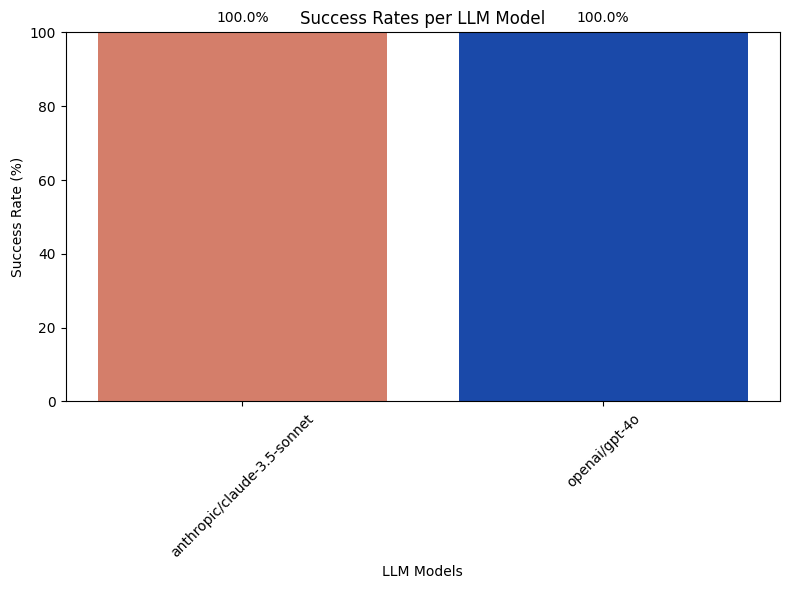

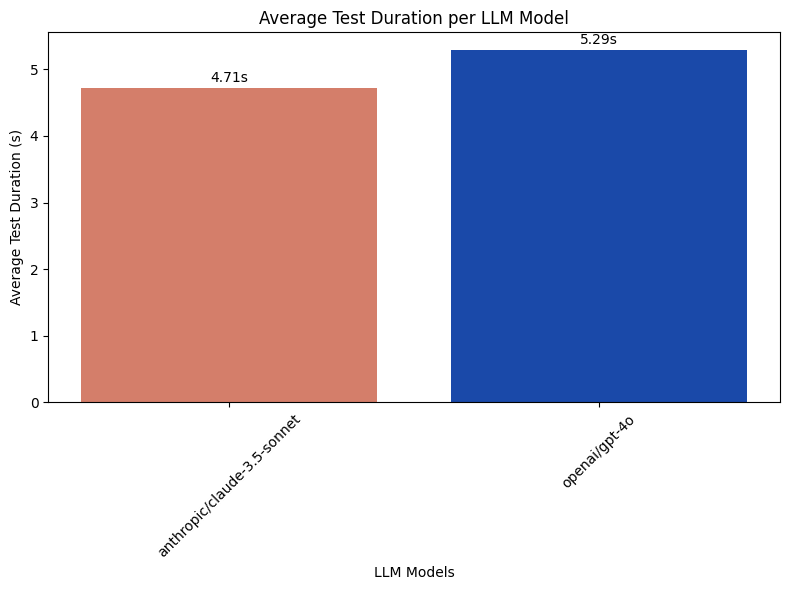

In [6]:
import matplotlib.pyplot as plt
import concurrent.futures
import time
import datetime
from colorama import Fore, Style, init as colorama_init
import hashlib
colorama_init(autoreset=True)

objects_list = df.apply(lambda row: [obj for obj in row if obj is not None], axis=1).tolist()

def get_color_from_string(s: str) -> str:
    """Generate a consistent color from a string using hashing"""
    hash_object = hashlib.md5(s.encode())
    hash_hex = hash_object.hexdigest()
    # Use first 6 characters of hash for RGB color
    return f"#{hash_hex[:6]}"

def test_model(model: str, objects_list: list) -> tuple:
    """
    For the given model, run tests for each set of objects, printing logs with:
       - Timestamp
       - Colored status (green for Passed, red for Failed)
       - Current success rate (so far)
       - Current average test duration (so far)
    
    Returns a tuple: (model, successes, failures, avg_duration)
    """
    successes = 0
    failures = 0
    durations = []  # list to record the duration of each test iteration

    # Instantiate client and subtasks generator for the model
    llm_client = LlmClient(llm_api_key, model, llm_base_url)
    subtasks_gen = SubtasksGenerator(llm_client)

    for i, objects in enumerate(objects_list):
        start_time = time.time()
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        try:
            subtasks_gen.gen_subtask_paths(objects)
            successes += 1
            result_text = "Passed"
            result_color = Fore.GREEN
        except Exception:
            failures += 1
            result_text = "Failed"
            result_color = Fore.RED

        iteration_duration = time.time() - start_time
        durations.append(iteration_duration)
        current_success_rate = (successes / (i + 1)) * 100
        current_avg_duration = sum(durations) / len(durations)

        print(f"{timestamp} | [{model}] iteration #{i+1} "
              f"{result_color}{result_text}{Style.RESET_ALL} | "
              f"Current success rate: {current_success_rate:.2f}% | "
              f"Current avg duration: {current_avg_duration:.2f}s")

    avg_duration = sum(durations) / len(durations) if durations else 0
    return model, successes, failures, avg_duration

results = []  # will store tuples: (model, successes, failures, avg_duration)

if RUN_PARALLEL:
    with concurrent.futures.ThreadPoolExecutor(max_workers=len(AVAILABLE_MODELS)) as executor:
        future_to_model = {
            executor.submit(test_model, model, objects_list): model
            for model in AVAILABLE_MODELS
        }
        for future in concurrent.futures.as_completed(future_to_model):
            result = future.result()
            results.append(result)
else:
    for model in AVAILABLE_MODELS:
        result = test_model(model, objects_list)
        results.append(result)

# -----------------------------------------------------------------------------
# Print summary and collect data for graphs
# -----------------------------------------------------------------------------
print("\nSummary:")
model_names = []
success_rates = []
avg_durations = []

for model, successes, failures, avg_duration in results:
    total = successes + failures
    success_rate = (successes / total * 100) if total > 0 else 0
    print(f"{model}: {successes}/{total} passed ({success_rate:.2f}%), "
          f"Avg test duration: {avg_duration:.2f}s")
    model_names.append(model)
    success_rates.append(success_rate)
    avg_durations.append(avg_duration)

# Generate colors based on model names
model_colors = [get_color_from_string(model) for model in model_names]

# -----------------------------------------------------------------------------
# Graph 1: Success Rates per Model
# -----------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
bars1 = plt.bar(model_names, success_rates, color=model_colors)
plt.xlabel('LLM Models')
plt.ylabel('Success Rate (%)')
plt.title('Success Rates per LLM Model')
plt.ylim(0, 100)
plt.xticks(rotation=45)

for bar, rate in zip(bars1, success_rates):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 2, f'{rate:.1f}%', ha='center', va='bottom')

plt.tight_layout()

# -----------------------------------------------------------------------------
# Graph 2: Average Test Duration per Model
# -----------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
bars2 = plt.bar(model_names, avg_durations, color=model_colors)
plt.xlabel('LLM Models')
plt.ylabel('Average Test Duration (s)')
plt.title('Average Test Duration per LLM Model')
plt.xticks(rotation=45)

for bar, duration in zip(bars2, avg_durations):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.05, f'{duration:.2f}s', ha='center', va='bottom')

plt.tight_layout()
plt.show()